Il s'agit ici de la fonction QuickCertify qui est la premiere etape de notre methode de Test Systematique de la robustesse des modeles KNN. Ici, a partir de certaines conditions, nous verifions la robustesse. Ces conditions suffisantes sont conçues pour éviter l’étape la plus coûteuse de l’algorithme KNN, qui est la phase d’apprentissage qui s’appuie sur des validations croisées p-fold pour calculer le paramètre K optimal.

In [1]:
import numpy as np

# Cette fonction calcule la distance euclidienne entre deux points
def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [2]:
from collections import Counter

# Calculer la distance euclidienne entre les points du dataset pour pouvoir les comparer et obtenir le label le plus fréquent dans les k plus proches voisins
def mostFreqLabel(data, k, input_x, y=None, n=None):
    # Calculate the distance between input_x and all points in the data
    distances = [(euclidean_distance(input_x, x), label) for x, label in data]


    # Calculer le removal set 
    if y is not None:
        
        # Sort the distances and get the labels of the k+n nearest neighbors
        if n is not None :
            labels = [label for _, label in sorted(distances)[:k+n]]
            # Supprimer n éléments ayant pour label y
            count = 0
            j = len(labels) - 1  # Commencer par la fin de la liste
            while count < n and j >= 0:
                if labels[j] == y:
                    labels.pop(j)
                    count += 1
                j -= 1
        else:
            # Erreur dans les parametres de la fonction 
            print("Erreur dans les parametres de la fonction")
            exit()
    else:
        # Sort the distances and get the labels of the k nearest neighbors
        labels = [label for _, label in sorted(distances)[:k]]        

    # Get the most common label
    most_common_label = Counter(labels).most_common(1)[0][0]

    return most_common_label


In [5]:
def QuickCertify(data, n, input_x):
    label_set = [] # To store the most frequent labels for each value of K[^1^][1]
    K = {1, 2, 3} # Set of K values

    for k in K:
        y = mostFreqLabel(data, k, input_x)
        label_set.append(y)
        
        print('---', y, '---')
        
        # Most frequent label after removal[^2^][2]
        y_prime = mostFreqLabel(data, k, input_x, y, n)

        if y != y_prime:
            return False

        # If all the most frequent labels are not the same, return False
        if len(set(label_set)) > 1:
            return False
        
    return True

data = [
    ([1.2, 3.5], 'Star'),
    ([2.5, 4.8], 'Star'),
    ([3.7, 2.1], 'Star'),
    ([5.1, 6.2], 'Triangle'),
    ([6.9, 1.8], 'Triangle'),
    ([7.5, 5.5], 'Triangle'),
    ([9.2, 8.1], 'Star'),
    ([8.5, 7.4], 'Triangle'),
    ([0.5, 1.9], 'Star')
]
n = 2
input_x = [5, 4.5]

print(QuickCertify(data, n, input_x))

--- Triangle ---
False


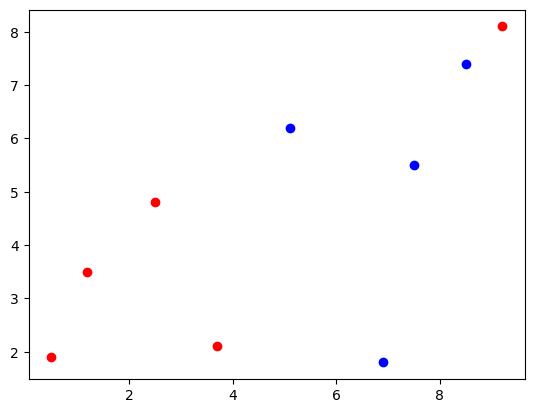

In [6]:
import matplotlib.pyplot as plt

data = [
    ([1.2, 3.5], 'Star'),
    ([2.5, 4.8], 'Star'),
    ([3.7, 2.1], 'Star'),
    ([5.1, 6.2], 'Triangle'),
    ([6.9, 1.8], 'Triangle'),
    ([7.5, 5.5], 'Triangle'),
    ([9.2, 8.1], 'Star'),
    ([8.5, 7.4], 'Triangle'),
    ([0.5, 1.9], 'Star')
]

for point in data:
    if point[1] == 'Star':
        plt.scatter(point[0][0], point[0][1], color='red')
    elif point[1] == 'Triangle':
        plt.scatter(point[0][0], point[0][1], color='blue')
    elif point[1] == 'Square':
        plt.scatter(point[0][0], point[0][1], color='green')

plt.show()
